In [30]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [31]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# No. of classes

In [32]:
NUM_CLASSES = 3

# Input Length

In [33]:
TIME_STEPS = 16
DIMENSION = 2

# Reading Training Data

In [34]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [35]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Building

In [37]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [38]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 24)                792       
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                250       
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,075
Trainable params: 1,075
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [40]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [41]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 0.1212
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.hdf5
1/1 [==============================] - 0s 397ms/step - loss: 1.1298 - accuracy: 0.1212 - val_loss: 1.1153 - val_accuracy: 0.1364
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.1515
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.hdf5
1/1 [==============================] - 0s 33ms/step - loss: 1.1124 - accuracy: 0.1515 - val_loss: 1.1121 - val_accuracy: 0.6364
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 1.1020 - accuracy: 0.7576
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.hdf5
1/1 [==============================] - 0s 31ms/step - loss: 1.1020 - accuracy: 0.7576 - val_loss: 1.1093 - val_accuracy: 0.6364
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 1.0977 

In [42]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [43]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 37ms/step
[0.04748593 0.05732296 0.8951911 ]
2


# Confusion Matrix

1/1 [==============================] - 0s 12ms/step


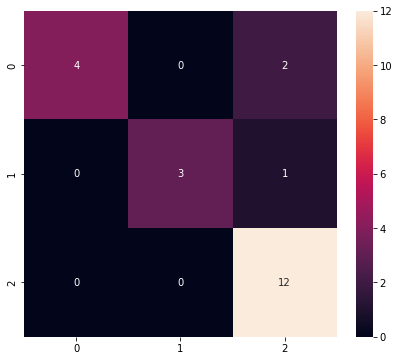

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89        12

    accuracy                           0.86        22
   macro avg       0.93      0.81      0.85        22
weighted avg       0.89      0.86      0.86        22



In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert model for Tensorflow Lite

In [45]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [46]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [47]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ezs03\AppData\Local\Temp\tmpls_sufs_\assets


INFO:tensorflow:Assets written to: C:\Users\ezs03\AppData\Local\Temp\tmpls_sufs_\assets


6360

# Inference Test

In [48]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [49]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [50]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [51]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [52]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.04748591 0.05732297 0.89519113]
2
